V-shaped transits can be caused grazing planets, or by eclipsing binaries whose light contaminates the mask of the target star. The probability for the latter can be estimated using high-resolution imaging and radial velocity measurements.

The sensitivity of BLS to V-shaped transits is reduced by ~50%, as the filter mismatch is much larger compared to more box-like transit shapes. This is problematic for small planets, where the signal is sufficient for detection, but the planet is not apparent in the BLS power spectrum. These planets can efficiently be detected by setting TLS up for V-shaped transits.

We start our tutorial by downloading and detrending the data for K2-31b [(Grziwa et al. 2016)](http://iopscience.iop.org/article/10.3847/0004-6256/152/5/132/pdf), a known grazing hot Jupiter. The approach is similar to the previous tutorials. This time, however, the [Everest](https://github.com/rodluger/everest) light curve has some weird outliers in it, including negative flux values. In a correct analysis of this planet, one would careful examine and treat the data. In this tutorial, we simply remove questionable data points.

In [2]:
import numpy
import scipy
import everest
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)

EPIC_id = 204129699        
star = everest.Everest(EPIC_id)
t = star.time
y = star.fcor
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')
t = t[y>800000]  # Threshold to remove questionable data
y = y[y>800000]
y = y.tolist()  # Clear array from mask
t = t.tolist()
y = numpy.asarray(y)
t = numpy.asarray(t)
trend = scipy.signal.medfilt(y, 25)
y_filt = y /trend

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("Flux (electrons per sec)")
ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Flux");

/home/michael/.local/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 204129699.


As we can visually identify the transit with a depth of ~0.5% (=5000ppm), we use 500ppm as the ``transit_depth_min`` to speed up our calculations. Now the crucial step is to specify a grazing model. For comparison, we also run a steep trapezoid, approximating a classical BLS search:

Creating model cache for 45  durations
Searching 3739 data points, 13717 periods from 0.602 to 38.871 days, using all 8 CPU threads


100%|██████████| 13717/13717 periods | 00:20<00:00
  5%|▌         | 200/3739 [00:00<00:01, 1997.89it/s]

Searching for best T0 for period 1.25786


100%|██████████| 3739/3739 [00:00<00:00, 7042.92it/s]
/home/michael/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/michael/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating model cache for 45  durations
Searching 3739 data points, 13717 periods from 0.602 to 38.871 days, using all 8 CPU threads


100%|██████████| 13717/13717 periods | 00:19<00:00
 23%|██▎       | 852/3739 [00:00<00:00, 8512.24it/s]

Searching for best T0 for period 1.25786


100%|██████████| 3739/3739 [00:00<00:00, 8513.90it/s]
/home/michael/Desktop/Google Drive/Research/ld-transit/current code/TransitLeastSquares.py:1257: RuntimeWarning: divide by zero encountered in double_scalars
  snr_pink_per_transit[i] = (1 - mean_flux) / pinknoise


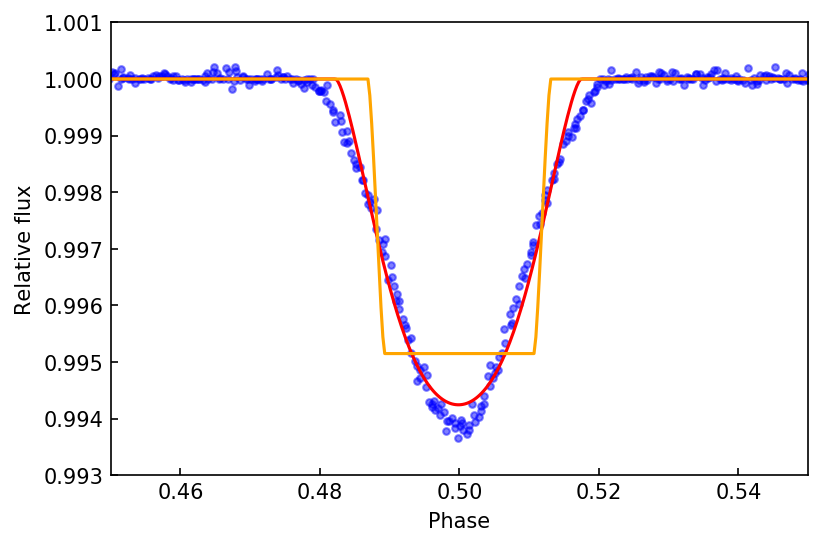

In [3]:
from TransitLeastSquares import TransitLeastSquares
model_grazing = TransitLeastSquares(t, y_filt)
results_grazing = model_grazing.power(
    transit_depth_min=500*10**-6,
    oversampling_factor=5,
    transit_template='grazing')

model_box = TransitLeastSquares(t, y_filt)
results_box= model_box.power(
    transit_depth_min=500*10**-6,
    oversampling_factor=5,
    transit_template='box')


from matplotlib import rcParams; rcParams["figure.dpi"] = 150
ax.get_yaxis().set_tick_params(which='both', direction='out')
ax.get_xaxis().set_tick_params(which='both', direction='out')

plt.plot(
    results_grazing.model_folded_phase,
    results_grazing.model_folded_model,
    color='red')
plt.scatter(
    results_grazing.folded_phase,
    results_grazing.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)

plt.plot(
    results_box.model_folded_phase,
    results_box.model_folded_model,
    color='orange')

plt.xlim(0.45, 0.55)
plt.ylim(0.993, 1.001)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

The box-shaped transit template is, as expected, a much worse fit. But how much does this mismatch actually affect detection efficiency? For such a deep transit, the difference is irrelevant. But for transits with lower SNR, it is useful to know the difference.

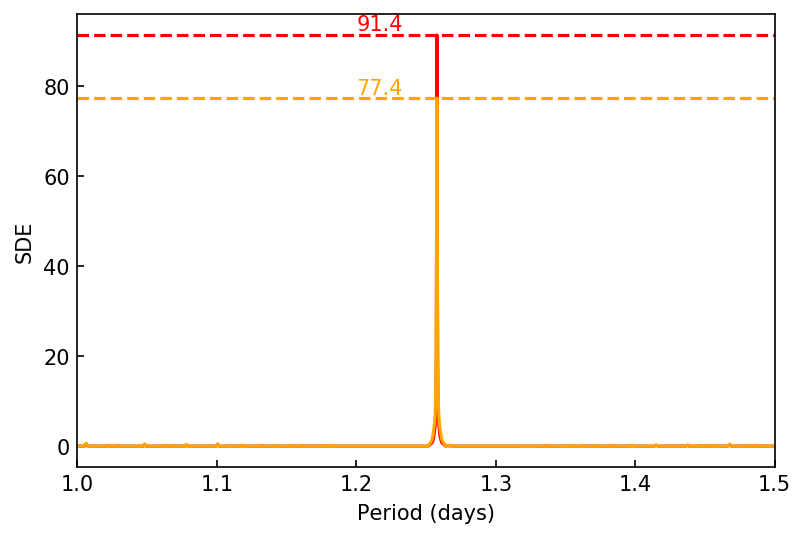

In [4]:
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_grazing.periods, results_grazing.power, color='red')
plt.plot(results_box.periods, results_box.power, color='orange')
plt.plot((1, 1.5), (results_grazing.SDE, results_grazing.SDE), color='red', linestyle='dashed')
plt.plot((1, 1.5), (results_box.SDE, results_box.SDE), color='orange', linestyle='dashed')
plt.text(1.2, results_box.SDE*1.01, format(results_box.SDE, '.1f'), color='orange')
plt.text(1.2, results_grazing.SDE*1.01, format(results_grazing.SDE, '.1f'), color='red')
plt.xlim(1, 1.5);

So the difference in signal detection efficiency is ~91.4/77.4 ~ 18%. For a true box and BLS' binning, it is a few percent more than that. Of course, the actual difference in other cases depends on many factors, such as noise levels and signal shapes. But the 20% (order of magnitude) difference is what one should expect.